In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mlt
import seaborn as sns
mlt.style.use('fivethirtyeight')
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import copy

In [46]:
raw_data = pd.read_csv("matches.csv")
ball_by_ball_data = pd.read_csv("deliveries.csv")


In [47]:
raw_data.head(1)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN


In [48]:
ball_by_ball_data.head(1)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN


In [49]:
Team_Names = {'Sunrisers Hyderabad':"SRH", 'Rising Pune Supergiant':"RPS",
       'Kolkata Knight Riders':"KKR", 'Kings XI Punjab':"KXIP",
       'Royal Challengers Bangalore':"RCB", 'Mumbai Indians':"MI",
       'Delhi Daredevils':"DD", 'Gujarat Lions':"GL", 'Chennai Super Kings':"CSK",
       'Rajasthan Royals':"RR", 'Deccan Chargers':"DC", 'Pune Warriors':"PWI",
       'Kochi Tuskers Kerala':"KTK", 'Rising Pune Supergiants':"RPS"}
raw_data = raw_data.replace(Team_Names.keys() , Team_Names.values())
ball_by_ball_data = ball_by_ball_data.replace(Team_Names.keys() , Team_Names.values())
raw_data = raw_data.drop(["umpire3"], axis = 1)



In [50]:
raw_data.head(2)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2
0,1,2017,Hyderabad,2017-04-05,SRH,RCB,RCB,field,normal,0,SRH,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong
1,2,2017,Pune,2017-04-06,MI,RPS,RPS,field,normal,0,RPS,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi


In [54]:
ball_by_ball_data.head(5)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,SRH,RCB,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,SRH,RCB,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,SRH,RCB,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,SRH,RCB,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,SRH,RCB,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [55]:
#Dropping non-required columns from ball_by_ball dataframe

ball_by_ball_data_refined = ball_by_ball_data.drop(['is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs','player_dismissed',
       'dismissal_kind', 'fielder'], axis = 1)



In [56]:
#We want only first innings data
#Including only those entries to the dataset which correspond to the first innings of a match
first_innings_ball_by_ball_data_refined = ball_by_ball_data_refined[ball_by_ball_data_refined['inning'] == 1]
first_innings_ball_by_ball_data_refined.tail()


#Grouping the dataframe in terms of separate matches.
#Each group is a dataframe consisting of data of first innings of one particular match
sep_matches = first_innings_ball_by_ball_data_refined.groupby(["match_id"])


#Iterating over each group,i.e., effectively iterating over each match.
#Grouping each match in terms of overs and balls to find out those matches where 20 overs have not been bowled.
#If (20,6) is not present in the groups obtained, it implies theinnings was over before the 6th ball of the 20th over.
#In that case, we are discarding those matches and only including matches where entire 20 overs have been bowled.
completed_first_innings_ball_by_ball_data_refined = pd.DataFrame()
for group in sep_matches.groups:
    a = sep_matches.get_group(group)
    if (20,6) in a.groupby(['over','ball']).groups.keys():
        completed_first_innings_ball_by_ball_data_refined = pd.concat([completed_first_innings_ball_by_ball_data_refined,a], axis = 0)
    
    
    
# To check if completed_first_innings_ball_by_ball_data_refined contains data of only
# those matches which have had complete 20 overs in the first innings
# For completed matches, the lengths of dataframes of each group of matches should be greater than equal to 120
sep_overs_and_balls = completed_first_innings_ball_by_ball_data_refined.groupby(['match_id'])
for group in sep_overs_and_balls.groups:
    a = sep_overs_and_balls.get_group(group)
    if len(a)<120:
        print(len(a) + "Error")
        
        
#Calculating the total runs scored in the first innings of each match
#Iterating through each group (each match), and summing the 'total_runs' column 
#'total_runs' represents runs scored in each ball. Adding the runs scored in each ball to calculate total score.
total = []

for group in sep_matches.groups:
    a = sep_matches.get_group(group)
    total.append(a['total_runs'].sum())
    
#Creating a new extended dataframe to account for the new columns.
extended_raw_data = copy.deepcopy(raw_data)
extended_raw_data['First_Innings_Total'] = total

In [58]:
#We want only second innings data
#Including only those entries to the dataset which correspond to the second innings of a match
second_innings_ball_by_ball_data_refined = ball_by_ball_data_refined[ball_by_ball_data_refined['inning'] == 2]
second_innings_ball_by_ball_data_refined.head()


#Grouping the dataframe in terms of separate matches.
#Each group is a dataframe consisting of data of second innings of one particular match
sep_matches_2nd = second_innings_ball_by_ball_data_refined.groupby(["match_id"])


#Calculating the total runs scored in the first innings of each match
#Iterating through each group (each match), and summing the 'total_runs' column 
#'total_runs' represents runs scored in each ball. Adding the runs scored in each ball to calculate total score.
total_2nd = []
for group in sep_matches_2nd.groups:
    a = sep_matches_2nd.get_group(group)
    total_2nd.append(a['total_runs'].sum())
    
len(total_2nd)#Length of total_2nd is 634 whereas total_1st is 636 because there were 2 matches where 2nd innings wasn't played.

#Removing the matches which ended as no result from the extended_raw_data dataframe
extended_raw_data = extended_raw_data[extended_raw_data['result'] != 'no result']


#3 matches were no result, out of which 2nd innings didn't start on 2 occassions and it started once but didn't go upto 5 overs.
#Upon searching through the data, I found the anomalous match was match id 569.
#Here we omit the 568th index from the total_2nd list as it corresponds to the 569th match.
total_2nd_new = total_2nd[:568] + total_2nd[569:]


extended_raw_data['Second_Innings_Total'] = total_2nd_new

extended_raw_data.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,First_Innings_Total,Second_Innings_Total
0,1,2017,Hyderabad,2017-04-05,SRH,RCB,RCB,field,normal,0,SRH,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,207,172
1,2,2017,Pune,2017-04-06,MI,RPS,RPS,field,normal,0,RPS,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,184,187
2,3,2017,Rajkot,2017-04-07,GL,KKR,KKR,field,normal,0,KKR,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,183,184
3,4,2017,Indore,2017-04-08,RPS,KXIP,KXIP,field,normal,0,KXIP,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,163,164
4,5,2017,Bangalore,2017-04-08,RCB,DD,RCB,bat,normal,0,RCB,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,157,142


In [63]:
#Creating a new dataframe consisting of data of only those matches which weren't affected by rain or any other issue.
#Basically including only complete 20 over matches.
only_full_matches_data = extended_raw_data[raw_data["dl_applied"] == 0]
only_full_matches_data = only_full_matches_data.drop(['dl_applied'], axis = 1)
#Removing entries which have missing data
only_full_matches_data = only_full_matches_data.dropna(axis=0)
#Setting the id column as index
only_full_matches_data.set_index("id",inplace=True)
only_full_matches_data.head(3)



C:\ProgramData\Anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 1 to 636
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   season                609 non-null    int64 
 1   city                  609 non-null    object
 2   date                  609 non-null    object
 3   team1                 609 non-null    object
 4   team2                 609 non-null    object
 5   toss_winner           609 non-null    object
 6   toss_decision         609 non-null    object
 7   result                609 non-null    object
 8   winner                609 non-null    object
 9   win_by_runs           609 non-null    int64 
 10  win_by_wickets        609 non-null    int64 
 11  player_of_match       609 non-null    object
 12  venue                 609 non-null    object
 13  umpire1               609 non-null    object
 14  umpire2               609 non-null    object
 15  First_Innings_Total   609 non-null    in

,season,city,date,team1,team2,toss_winner,toss_decision,result,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,First_Innings_Total,Second_Innings_Total
id,,,,,,,,,,,,,,,,,
1,2017,Hyderabad,2017-04-05,SRH,RCB,RCB,field,normal,SRH,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,207,172
2,2017,Pune,2017-04-06,MI,RPS,RPS,field,normal,RPS,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,184,187
3,2017,Rajkot,2017-04-07,GL,KKR,KKR,field,normal,KKR,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,183,184
4,2017,Indore,2017-04-08,RPS,KXIP,KXIP,field,normal,KXIP,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,163,164
6,2017,Hyderabad,2017-04-09,GL,SRH,SRH,field,normal,SRH,0,9,Rashid Khan,"Rajiv Gandhi International Stadium, Uppal",A Deshmukh,NJ Llong,135,140


In [64]:
#Sorting the only_full_matches_data by the win_by_runs column 
test = only_full_matches_data.sort_values(by="win_by_runs", ascending = False)
#Creating a new dataframe consisting of matches where a team won by 80 runs or more  
#Its purpose is to see which team has won most one sided matches while batting first
test_2 = test[test["win_by_runs"]>80]
test_2
test_2["winner"].value_counts()

CSK     5
RCB     4
MI      3
RR      2
KKR     2
DC      1
SRH     1
DD      1
KXIP    1
Name: winner, dtype: int64


Biggest wins in terms of runs has been registered by Mumbai Indians - 146 runs.
Chennai Super Kings have 5 out of the top 20 biggest wins by runs, most for any team.
Royal Challengers Bangalore have 4.



In [69]:
#Grouping the only_full_matches_data dataframe by team1 and team2
#Basically creating groups containing all the matches between any two particular teams.
gb = only_full_matches_data.groupby(['team1','team2'])


head_to_head = [[]]
# Creates a list of all teams which have played head to head in IPL
for key in gb.groups.keys():
    key = list(key)
    head_to_head.append(key)

#Create a copy of the head_to_head list.
head_to_heads = copy.deepcopy(head_to_head)

#print(head_to_heads)
#Removes duplicates from the list
#For example, ['CSK',"MI"] and ["MI","CSK"] are two different values in the list
for i in range(1,len(head_to_heads)):
    team1 = head_to_heads[i][0]
    team2 = head_to_heads[i][1]
    for j in range(1,i):
        if head_to_heads[j][0] == team2 and head_to_heads[j][1] == team1:   #Checks every inner list unpto the ith list to see if there is any list containing the elements of ith list but in reverse order
            head_to_heads[i][0] = 'x'   #If a reverse duplicate is found, one element of the duplicate list is set to 'x' to flag it as duplicate.
            break
    



In [74]:
#Checks if any inner list is flagged. If yes, then it removes the inner list.
i = 1
while i < len(head_to_heads):
    if head_to_heads[i][0] == 'x':
        head_to_heads.pop(i)
    i+=1

In [76]:
#Creates a dictionary of dataframes where team names are the keys and the corresponding head to head matches data are the values 

frames = {}

for i in range(1,len(head_to_heads)):
    a = gb.get_group((head_to_heads[i][0],head_to_heads[i][1]))
    if [head_to_heads[i][1],head_to_heads[i][0]] in head_to_head:
        b = gb.get_group((head_to_heads[i][1],head_to_heads[i][0]))
        frames[head_to_heads[i][0] + "v" + head_to_heads[i][1]] = pd.concat([a,b],axis = 0)
        frames[head_to_heads[i][0] + "v" + head_to_heads[i][1]] = frames[head_to_heads[i][0] + "v" + head_to_heads[i][1]].drop(["team1","team2","umpire1","umpire2","result"], axis = 1)
    else:
        frames[head_to_heads[i][0] + "v" + head_to_heads[i][1]] = a
        frames[head_to_heads[i][0] + "v" + head_to_heads[i][1]] = frames[head_to_heads[i][0] + "v" + head_to_heads[i][1]].drop(["team1","team2","umpire1","umpire2","result"], axis = 1)



In [81]:
frames["CSKvMI"]

,season,city,date,toss_winner,toss_decision,winner,win_by_runs,win_by_wickets,player_of_match,venue,First_Innings_Total,Second_Innings_Total
id,,,,,,,,,,,,
67,2008,Chennai,2008-04-23,MI,field,CSK,6,0,ML Hayden,"MA Chidambaram Stadium, Chepauk",208,202
96,2008,Mumbai,2008-05-14,MI,field,MI,0,9,ST Jayasuriya,Wankhede Stadium,156,158
194,2010,Mumbai,2010-03-25,MI,field,MI,0,5,SR Tendulkar,Brabourne Stadium,180,181
211,2010,Chennai,2010-04-06,CSK,bat,CSK,24,0,SK Raina,"MA Chidambaram Stadium, Chepauk",165,141
234,2010,Mumbai,2010-04-25,CSK,bat,CSK,22,0,SK Raina,Dr DY Patil Sports Academy,168,146
308,2012,Chennai,2012-04-04,MI,field,MI,0,8,RE Levi,"MA Chidambaram Stadium, Chepauk",112,115
355,2012,Mumbai,2012-05-06,MI,field,MI,0,2,DR Smith,Wankhede Stadium,173,174
379,2012,Bangalore,2012-05-23,MI,field,CSK,38,0,MS Dhoni,M Chinnaswamy Stadium,187,149
454,2013,Delhi,2013-05-21,CSK,bat,CSK,48,0,MEK Hussey,Feroz Shah Kotla,192,144


Mumbai Indians vs Chennai Super Kings
Matches - 21
MI - 12
CSK - 9

In [83]:
extended_raw_data["result"].value_counts()
only_full_matches_data["result"].value_counts()

normal    626
tie         7
Name: result, dtype: int64

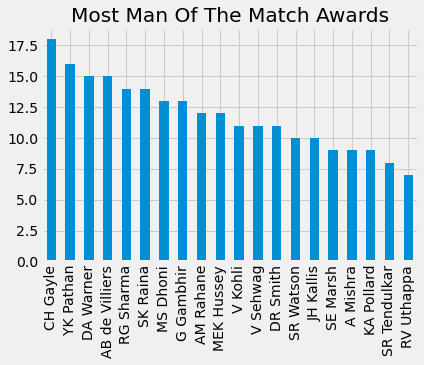

In [84]:
#Extracting the Man of The Match data from the extended_raw_data dataframe
most_MoMs = extended_raw_data["player_of_match"].value_counts()
most_MoMs = most_MoMs[:20]
most_MoMs

most_MoMs.plot.bar(title = "Most Man Of The Match Awards")

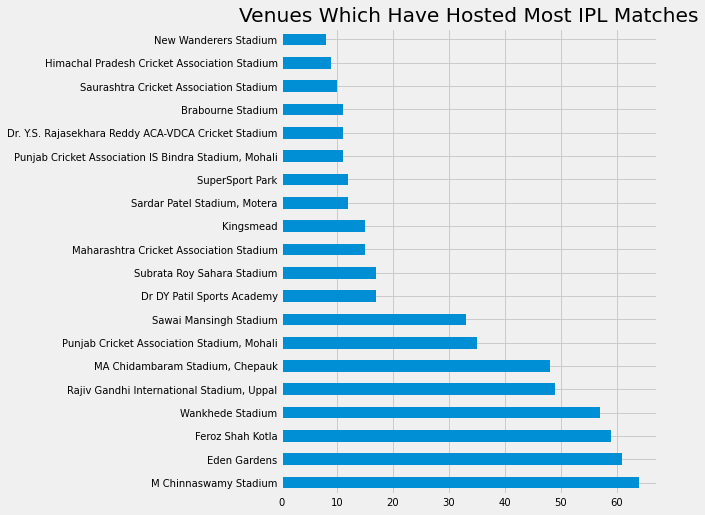

In [85]:
#Extracting the venues data
venues = extended_raw_data["venue"].value_counts()
venues = venues[:20]
venues.plot.barh(figsize=(6,8), fontsize=10, title = "Venues Which Have Hosted Most IPL Matches")

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, HDPK Dharmasena to SD Fry
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   no_of_matches  89 non-null     int64
dtypes: int64(1)
memory usage: 1.4+ KB


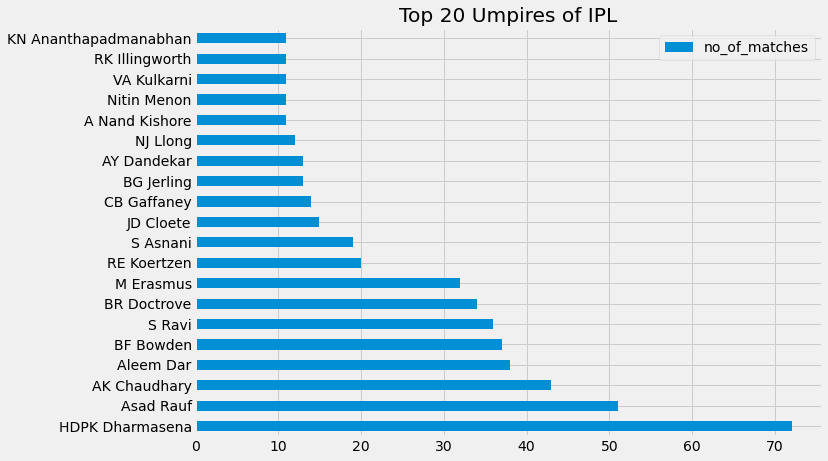

In [88]:
umpires = pd.DataFrame()
umpires2 = pd.DataFrame()
umpires["no_of_matches"] = extended_raw_data["umpire1"].value_counts()
umpires2["no_of_matches"] = extended_raw_data["umpire2"].value_counts()
umpires = pd.concat([umpires,umpires2], axis = 0)
umpires.sort_values(by="no_of_matches", ascending = False)
top_umpires = umpires[:20]

top_umpires.plot.barh(figsize = (10,7), title = "Top 20 Umpires of IPL")

In [ ]:
#sep_overs = first_innings_ball_by_ball_data_refined.groupby(["over"])
over_by_over_runs_1st_innings = pd.DataFrame()
over_by_over_runs_1st_innings[['Id','Season','Winner','Won_by___wickets',
                  'Won_by___runs','Venue',
                  'First_Innings_Total','Second_Innings_Total']] = extended_raw_data[['id','season','winner','win_by_wickets',
                                                                            'win_by_runs','venue',
                                                                           'First_Innings_Total','Second_Innings_Total']]

#Initialising the columns Batting Team and Bowling team with dashes
#Initialising each column for PCT runs and Runs for every over with -1
#Not initialising with 0 because there may be maiden overs where runs scored were 0, so we have to keep track of them as well.
over_by_over_runs_1st_innings["Batting_Team"] = "---"
over_by_over_runs_1st_innings["Bowling_Team"] = "---"
for i in range(1,21):
    x = "PCT_Runs_in_over" + str(i)
    over_by_over_runs_1st_innings[x] = -1
for i in range(1,21):
    x = "Runs_in_over" + str(i)
    over_by_over_runs_1st_innings[x] = -1
                
                
over_by_over_runs_1st_innings.columns

In [91]:
#Rearranging the columns
over_by_over_runs_1st_innings = over_by_over_runs_1st_innings[['Id', 'Season', 'Venue', 'Batting_Team',
       'Bowling_Team','Runs_in_over1','Runs_in_over2','Runs_in_over3','Runs_in_over4',
       'Runs_in_over5','Runs_in_over6','Runs_in_over7','Runs_in_over8','Runs_in_over9',
       'Runs_in_over10','Runs_in_over11','Runs_in_over12','Runs_in_over13','Runs_in_over14',
       'Runs_in_over15','Runs_in_over16','Runs_in_over17','Runs_in_over18','Runs_in_over19',
       'Runs_in_over20', 'PCT_Runs_in_over1', 'PCT_Runs_in_over2',
       'PCT_Runs_in_over3', 'PCT_Runs_in_over4', 'PCT_Runs_in_over5',
       'PCT_Runs_in_over6', 'PCT_Runs_in_over7', 'PCT_Runs_in_over8',
       'PCT_Runs_in_over9', 'PCT_Runs_in_over10', 'PCT_Runs_in_over11',
       'PCT_Runs_in_over12', 'PCT_Runs_in_over13', 'PCT_Runs_in_over14',
       'PCT_Runs_in_over15', 'PCT_Runs_in_over16', 'PCT_Runs_in_over17',
       'PCT_Runs_in_over18', 'PCT_Runs_in_over19', 'PCT_Runs_in_over20',
       'First_Innings_Total', 'Second_Innings_Total','Winner', 'Won_by___wickets', 'Won_by___runs']]

over_by_over_runs_1st_innings.head(3)

,Id,Season,Venue,Batting_Team,Bowling_Team,Runs_in_over1,Runs_in_over2,Runs_in_over3,Runs_in_over4,Runs_in_over5,...,PCT_Runs_in_over16,PCT_Runs_in_over17,PCT_Runs_in_over18,PCT_Runs_in_over19,PCT_Runs_in_over20,First_Innings_Total,Second_Innings_Total,Winner,Won_by___wickets,Won_by___runs
0,1,2017,"Rajiv Gandhi International Stadium, Uppal",---,---,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,207,172,SRH,0,35
1,2,2017,Maharashtra Cricket Association Stadium,---,---,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,184,187,RPS,7,0
2,3,2017,Saurashtra Cricket Association Stadium,---,---,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,183,184,KKR,10,0


In [ ]:
#Separating each match into groups. Excluding match nos. 301,546 and 571 as they were no result matches.
#Extracting he First Innings total from the extended_raw_data for each match and storing it in total_runs
#Similarly extracting Batting team and Bowling team
#Grouping each atch into groups of overs, calculating total runs in an over, cummulative runs upto that over
#Entering the calculated values of run rate and total runs score for every over in the corresponding columns

for group in sep_matches.groups:
    #print(group)
    if(group == 301 or group == 546 or group == 571):
        continue
    else:
        a = sep_matches.get_group(group)
        match_id = a['match_id'].unique()
        idx = match_id - 1
        total_runs = extended_raw_data.loc[idx]["First_Innings_Total"]
        #print(total_runs)
        Batting_Team = a["batting_team"].unique()
        Bowling_Team = a["bowling_team"].unique()
        over_by_over_runs_1st_innings.loc[idx,"Batting_Team"] = Batting_Team
        over_by_over_runs_1st_innings.loc[idx,"Bowling_Team"] = Bowling_Team
        PCT_runs_in_over = [0]*20
        Runs_in_over = [0]*20
        cummulative_runs = 0
        sep_overs = a.groupby(['over'])
        for i in range (1,21):
            
            if i in sep_overs.groups.keys():
    
                b = sep_overs.get_group(i)
                runs_in_over = b['total_runs'].sum()
                cummulative_runs += runs_in_over
                PCT_runs_in_over[i-1] = round((cummulative_runs/i), 2)
                Runs_in_over[i-1] = runs_in_over 
                #print(PCT_runs_in_over[i-1])
                #break
                y = "PCT_Runs_in_over" + str(i)
                z = "Runs_in_over" + str(i)
                over_by_over_runs_1st_innings.loc[idx,y] = PCT_runs_in_over[i-1]
                over_by_over_runs_1st_innings.loc[idx,z] = Runs_in_over[i-1]

In [97]:
over_by_over_runs_1st_innings.head(3)

,Id,Season,Venue,Batting_Team,Bowling_Team,Runs_in_over1,Runs_in_over2,Runs_in_over3,Runs_in_over4,Runs_in_over5,...,PCT_Runs_in_over16,PCT_Runs_in_over17,PCT_Runs_in_over18,PCT_Runs_in_over19,PCT_Runs_in_over20,First_Innings_Total,Second_Innings_Total,Winner,Won_by___wickets,Won_by___runs
0,1,2017,"Rajiv Gandhi International Stadium, Uppal",SRH,RCB,7,16,6,4,9,...,9.69,9.53,9.94,10.05,10.35,207,172,SRH,0,35
1,2,2017,Maharashtra Cricket Association Stadium,MI,RPS,11,8,9,13,7,...,7.94,8.06,8.06,8.11,9.20,184,187,RPS,7,0
2,3,2017,Saurashtra Cricket Association Stadium,GL,KKR,8,8,6,7,11,...,8.12,8.29,8.50,8.89,9.15,183,184,KKR,10,0


In [100]:
#Using similar logic as above, creating an over_by_over_runs_2nd_innings dataframe.

#sep_overs = first_innings_ball_by_ball_data_refined.groupby(["over"])
over_by_over_runs_2nd_innings = pd.DataFrame()
over_by_over_runs_2nd_innings[['Id','Season','Winner','Won_by___wickets',
                  'Won_by___runs','Venue',
                  'First_Innings_Total','Second_Innings_Total']] = extended_raw_data[['id','season','winner','win_by_wickets',
                                                                            'win_by_runs','venue',
                                                                           'First_Innings_Total','Second_Innings_Total']]


over_by_over_runs_2nd_innings["Batting_Team"] = "---"
over_by_over_runs_2nd_innings["Bowling_Team"] = "---"
for i in range(1,21):
    x = "PCT_Runs_in_over" + str(i)
    over_by_over_runs_2nd_innings[x] = -1
for i in range(1,21):
    x = "Runs_in_over" + str(i)
    over_by_over_runs_2nd_innings[x] = -1
                
        
over_by_over_runs_2nd_innings = over_by_over_runs_2nd_innings[['Id', 'Season', 'Venue', 'Batting_Team',
       'Bowling_Team', 'Runs_in_over1','Runs_in_over2','Runs_in_over3','Runs_in_over4',
       'Runs_in_over5','Runs_in_over6','Runs_in_over7','Runs_in_over8','Runs_in_over9',
       'Runs_in_over10','Runs_in_over11','Runs_in_over12','Runs_in_over13','Runs_in_over14',
       'Runs_in_over15','Runs_in_over16','Runs_in_over17','Runs_in_over18','Runs_in_over19',
       'Runs_in_over20','PCT_Runs_in_over1', 'PCT_Runs_in_over2',
       'PCT_Runs_in_over3', 'PCT_Runs_in_over4', 'PCT_Runs_in_over5',
       'PCT_Runs_in_over6', 'PCT_Runs_in_over7', 'PCT_Runs_in_over8',
       'PCT_Runs_in_over9', 'PCT_Runs_in_over10', 'PCT_Runs_in_over11',
       'PCT_Runs_in_over12', 'PCT_Runs_in_over13', 'PCT_Runs_in_over14',
       'PCT_Runs_in_over15', 'PCT_Runs_in_over16', 'PCT_Runs_in_over17',
       'PCT_Runs_in_over18', 'PCT_Runs_in_over19', 'PCT_Runs_in_over20',
       'First_Innings_Total', 'Second_Innings_Total','Winner', 'Won_by___wickets', 'Won_by___runs']]



for group in sep_matches_2nd.groups:
    #print(group)
    if(group == 571):
        continue
    else:
        a = sep_matches_2nd.get_group(group)
        match_id = a['match_id'].unique()
        idx = match_id - 1
        total_runs = extended_raw_data.loc[idx]["First_Innings_Total"]
        #print(total_runs)
        Batting_Team = a["batting_team"].unique()
        Bowling_Team = a["bowling_team"].unique()
        over_by_over_runs_2nd_innings.loc[idx,"Batting_Team"] = Batting_Team
        over_by_over_runs_2nd_innings.loc[idx,"Bowling_Team"] = Bowling_Team
        PCT_runs_in_over = [0]*20
        Runs_in_over = [0]*20
        cummulative_runs = 0
        sep_overs = a.groupby(['over'])
        for i in range (1,21):
            
            if i in sep_overs.groups.keys():
    
                b = sep_overs.get_group(i)
                runs_in_over = b['total_runs'].sum()
                cummulative_runs += runs_in_over
                PCT_runs_in_over[i-1] = round((cummulative_runs/i), 2)
                Runs_in_over[i-1] = runs_in_over                 
                y = "PCT_Runs_in_over" + str(i)
                z = "Runs_in_over" + str(i)
                over_by_over_runs_2nd_innings.loc[idx,y] = PCT_runs_in_over[i-1]
                over_by_over_runs_2nd_innings.loc[idx,z] = Runs_in_over[i-1]

In [101]:
over_by_over_runs_2nd_innings.head(3)

,Id,Season,Venue,Batting_Team,Bowling_Team,Runs_in_over1,Runs_in_over2,Runs_in_over3,Runs_in_over4,Runs_in_over5,...,PCT_Runs_in_over16,PCT_Runs_in_over17,PCT_Runs_in_over18,PCT_Runs_in_over19,PCT_Runs_in_over20,First_Innings_Total,Second_Innings_Total,Winner,Won_by___wickets,Won_by___runs
0,1,2017,"Rajiv Gandhi International Stadium, Uppal",RCB,SRH,11,1,16,15,5,...,9.44,9.06,8.67,8.68,8.60,207,172,SRH,0,35
1,2,2017,Maharashtra Cricket Association Stadium,RPS,MI,8,15,12,4,4,...,9.25,9.29,9.17,9.05,9.35,184,187,RPS,7,0
2,3,2017,Saurashtra Cricket Association Stadium,KKR,GL,7,13,17,9,7,...,-1.00,-1.00,-1.00,-1.00,-1.00,183,184,KKR,10,0


In [102]:
def Over_by_Over_PCT_Runs_Breakdown(over_by_over_runs):
    over_by_over_PCT_Runs_breakdown = pd.DataFrame(columns = ["Over","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017"], index = range(0,20))
 

    for i in range(1,21):
        x = "PCT_Runs_in_over" + str(i)
        j = i-1
        over_by_over_PCT_Runs_breakdown["Over"][j] = x 

    years = over_by_over_runs.groupby(['Season'])

    for group in years.groups:
        c = years.get_group(group)
        for r in range(25,45):
            total_pct = 0
            total_matches = 0
            for j in range(len(c)):
                if c.iloc[j,r] != -1:
                    total_pct = total_pct + c.iloc[j,r]
                    total_matches = total_matches + 1
            avg = round(total_pct/total_matches, 2)
            k = r - 25
            over_by_over_PCT_Runs_breakdown.loc[k,str(group)] = avg
    
    
    over_by_over_PCT_Runs_breakdown = over_by_over_PCT_Runs_breakdown.set_index(['Over'])

    return over_by_over_PCT_Runs_breakdown


over_by_over_PCT_Runs_breakdown_1st_inngs = Over_by_Over_PCT_Runs_Breakdown(over_by_over_runs_1st_innings)
over_by_over_PCT_Runs_breakdown_2nd_inngs = Over_by_Over_PCT_Runs_Breakdown(over_by_over_runs_2nd_innings)

over_by_over_PCT_Runs_breakdown_1st_inngs.head()


,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Over,,,,,,,,,,
PCT_Runs_in_over1,5.31,5.46,6.53,6.33,4.99,5.01,6.53,5.96,5.52,6.1
PCT_Runs_in_over2,6.67,6.26,7.57,6.27,5.51,5.78,6.15,6.67,6.02,6.71
PCT_Runs_in_over3,6.71,6.63,7.76,6.68,6.19,6.34,6.51,7.46,6.19,7.46
PCT_Runs_in_over4,6.92,6.85,7.71,6.66,6.63,6.33,6.88,7.73,6.78,7.61
PCT_Runs_in_over5,7.25,7.09,7.82,6.81,6.86,6.68,7.17,7.78,7.14,7.69


In [103]:
over_by_over_PCT_Runs_breakdown_1st_inngs

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Over,,,,,,,,,,
PCT_Runs_in_over1,5.31,5.46,6.53,6.33,4.99,5.01,6.53,5.96,5.52,6.1
PCT_Runs_in_over2,6.67,6.26,7.57,6.27,5.51,5.78,6.15,6.67,6.02,6.71
PCT_Runs_in_over3,6.71,6.63,7.76,6.68,6.19,6.34,6.51,7.46,6.19,7.46
PCT_Runs_in_over4,6.92,6.85,7.71,6.66,6.63,6.33,6.88,7.73,6.78,7.61
PCT_Runs_in_over5,7.25,7.09,7.82,6.81,6.86,6.68,7.17,7.78,7.14,7.69
PCT_Runs_in_over6,7.48,7.34,7.83,7,7.12,6.84,7.38,7.8,7.31,7.88
PCT_Runs_in_over7,7.43,7.13,7.73,6.83,6.93,6.83,7.24,7.58,7.21,7.75
PCT_Runs_in_over8,7.35,7.04,7.58,6.92,6.99,6.82,7.27,7.54,7.2,7.62
PCT_Runs_in_over9,7.3,6.97,7.54,6.94,6.98,6.78,7.23,7.6,7.27,7.65


In [104]:
def Over_by_Over_Runs_breakdown(over_by_over_runs):
    over_by_over_Runs_breakdown = pd.DataFrame(columns = ["Over","2008","2009","2010","2011","2012","2013","2014","2015","2016","2017"], index = range(0,20))
 

    for i in range(1,21):
        x = "Runs_in_over" + str(i)
        j = i-1
        over_by_over_Runs_breakdown["Over"][j] = x 

    years = over_by_over_runs.groupby(['Season'])

    for group in years.groups:
        c = years.get_group(group)
        for r in range(5,25):
            total_runs = 0
            total_matches = 0
            for j in range(len(c)):
                if c.iloc[j,r] != -1:
                    total_runs = total_runs + c.iloc[j,r]
                    total_matches = total_matches + 1
            avg = round(total_runs/total_matches, 2)
            k = r - 5
            over_by_over_Runs_breakdown.loc[k,str(group)] = avg
    
    over_by_over_Runs_breakdown = over_by_over_Runs_breakdown.set_index(['Over'])
    
    return over_by_over_Runs_breakdown


over_by_over_Runs_breakdown_1st_inngs = Over_by_Over_Runs_breakdown(over_by_over_runs_1st_innings)
over_by_over_Runs_breakdown_2nd_inngs = Over_by_Over_Runs_breakdown(over_by_over_runs_2nd_innings)

In [105]:
over_by_over_Runs_breakdown_1st_inngs

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Over,,,,,,,,,,
Runs_in_over1,5.31,5.46,6.53,6.33,4.99,5.01,6.53,5.96,5.52,6.1
Runs_in_over2,8.03,7.07,8.6,6.21,6.03,6.54,5.77,7.37,6.52,7.32
Runs_in_over3,6.78,7.37,8.13,7.51,7.57,7.46,7.22,9.05,6.55,8.97
Runs_in_over4,7.55,7.49,7.58,6.58,7.93,6.32,8,8.53,8.55,8.05
Runs_in_over5,8.57,8.09,8.27,7.4,7.78,8.05,8.32,8,8.58,8.02
Runs_in_over6,8.64,8.56,7.88,7.96,8.43,7.64,8.47,7.89,8.15,8.83
Runs_in_over7,7.1,5.88,7.1,5.83,5.77,6.76,6.38,6.23,6.63,6.98
Runs_in_over8,6.79,6.44,6.5,7.54,7.39,6.76,7.47,7.3,7.1,6.64
Runs_in_over9,6.95,6.42,7.3,7.07,6.97,7.15,6.88,8.11,7.82,7.9


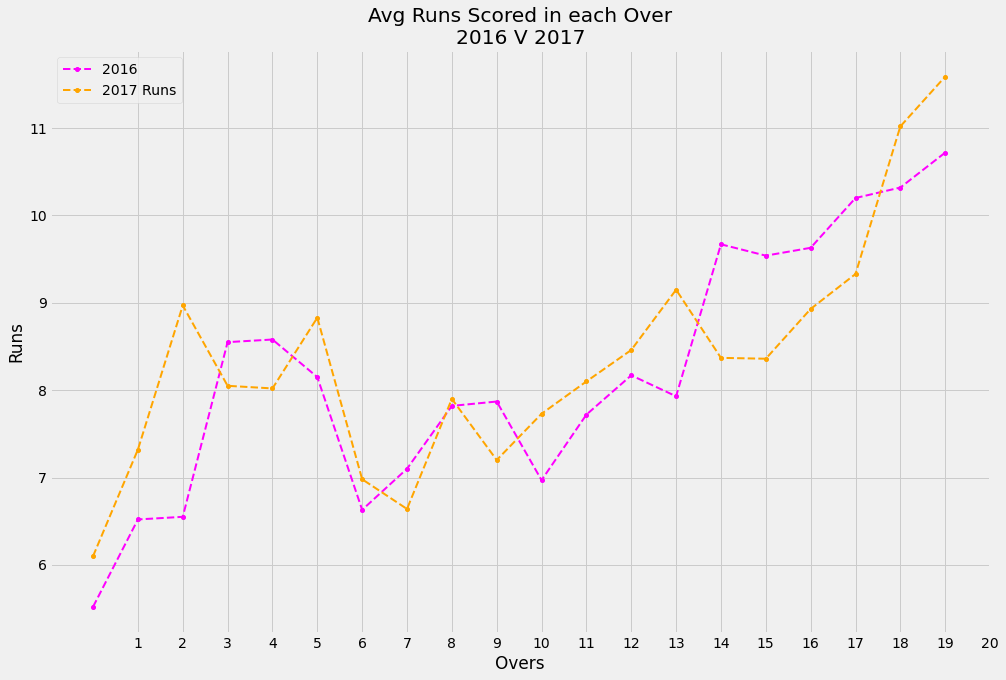

In [106]:
x = []
for i in range(2008,2018):
    x.append(over_by_over_Runs_breakdown_1st_inngs[str(i)])
mlt.figure(figsize=(15,10))

#mlt.plot(x[0], label = "2008", color='orange', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[1], label = "2009", color='red', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[2], label = "2010", color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[3], label = "2011", color='green', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[4], label = "2012", color='black', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[5], label = "2013", color='cyan', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[6], label = "2014", color='pink', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[7], label = "2015", color='yellow', marker='o', linestyle='dashed', linewidth=2, markersize=4)
mlt.plot(x[8], label = "2016", color='magenta', marker='o', linestyle='dashed', linewidth=2, markersize=4)
mlt.plot(x[9], label = "2017 Runs", color='orange', marker='o', linestyle='dashed', linewidth=2, markersize=4)


y = []
for i in range(2008,2018):
    y.append(over_by_over_PCT_Runs_breakdown_1st_inngs[str(i)])
#mlt.figure(figsize=(15,10))
x = x[:10]
#mlt.plot(y[0], label = "2008", color='orange', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[1], label = "2009", color='red', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[2], label = "2010", color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[3], label = "2011", color='green', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[4], label = "2012", color='black', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[5], label = "2013", color='cyan', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[6], label = "2014", color='pink', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[7], label = "2015", color='yellow', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[8], label = "2016", color='magenta', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[9], label = "2017 PCT Runs", color='brown', marker='o', linestyle='dashed', linewidth=2, markersize=4)


#Overs = [_ for _ in range(1,21)]
a = [_ for _ in range(1,21)]
mlt.xticks(a , a)
mlt.xlabel("Overs")
mlt.ylabel("Runs")
mlt.title("Avg Runs Scored in each Over\n2016 V 2017")
mlt.legend()
mlt.show()

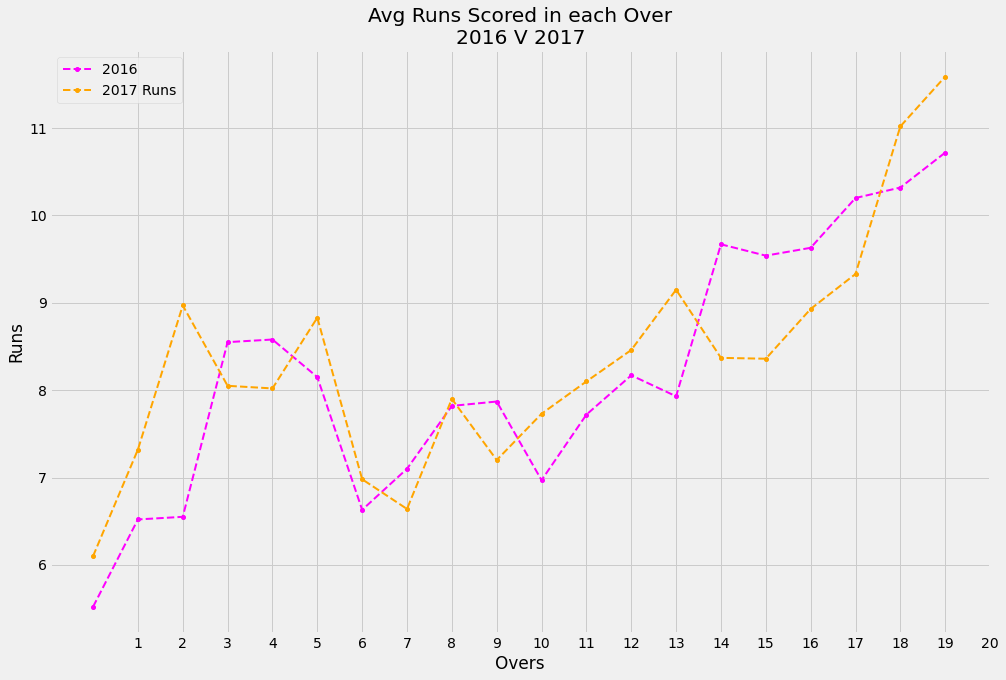

In [67]:
x = []
for i in range(2008,2018):
    x.append(over_by_over_Runs_breakdown_1st_inngs[str(i)])
mlt.figure(figsize=(15,10))

#mlt.plot(x[0], label = "2008", color='orange', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[1], label = "2009", color='red', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[2], label = "2010", color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[3], label = "2011", color='green', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[4], label = "2012", color='black', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[5], label = "2013", color='cyan', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[6], label = "2014", color='pink', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(x[7], label = "2015", color='yellow', marker='o', linestyle='dashed', linewidth=2, markersize=4)
lt.plot(x[8], label = "2016", color='magenta', marker='o', linestyle='dashed', linewidth=2, markersize=4)
mlt.plot(x[9], label = "2017 Runs", color='orange', marker='o', linestyle='dashed', linewidth=2, markersize=4)


y = []
for i in range(2008,2018):
    y.append(over_by_over_PCT_Runs_breakdown_1st_inngs[str(i)])
#mlt.figure(figsize=(15,10))
x = x[:10]
#mlt.plot(y[0], label = "2008", color='orange', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[1], label = "2009", color='red', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[2], label = "2010", color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[3], label = "2011", color='green', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[4], label = "2012", color='black', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[5], label = "2013", color='cyan', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[6], label = "2014", color='pink', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[7], label = "2015", color='yellow', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[8], label = "2016", color='magenta', marker='o', linestyle='dashed', linewidth=2, markersize=4)
#mlt.plot(y[9], label = "2017 PCT Runs", color='brown', marker='o', linestyle='dashed', linewidth=2, markersize=4)


#Overs = [_ for _ in range(1,21)]
a = [_ for _ in range(1,21)]
mlt.xticks(a , a)
mlt.xlabel("Overs")
mlt.ylabel("Runs")
mlt.title("Avg Runs Scored in each Over\n2016 V 2017")
mlt.legend()
mlt.show()

In [ ]:
help(mlt.plot)

In [ ]:
print('Toss Decisions in %\n',((raw_data['toss_decision']).value_counts())/636*100)

In [ ]:
mlt.subplots(figsize=(12,6))
sns.countplot(x='season',hue='toss_decision',data=raw_data, palette='Set1_r')
mlt.show()

In [ ]:
mlt.subplots(figsize=(13,6))
ax=raw_data['toss_winner'].value_counts().plot.bar(width=0.8,color=sns.color_palette('RdYlGn',5))
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.25, p.get_height()+2))
mlt.show()